In [1]:
# packages
import os
import re
import pandas as pd
import numpy as np
import glob
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime

# paths
load_dotenv()
root = os.getenv('root')
data = os.path.join(root, 'data')
results = os.path.join(root, 'results')
processed = os.path.join(data, 'processed')

In [2]:
#load
df = pd.read_csv(os.path.join(processed, 'symmetric_processed_not_encoded.csv'))

In [3]:
# transform date features
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
df['year'] = df['tourney_date'].dt.year
df['decimal_year'] = df['year'] + (df['tourney_date'].dt.day_of_year/365)

In [4]:
# drop features with no predictive power or redundant
df = df.drop(['tourney_date', 'match_num', 'Player_id_A', 
              'Player_id_B', 'Player_name_A', 'Player_name_B', 'Player_ioc_A', 'Player_ioc_B', #player_id, name and ioc should not have predictive power on performance
              'tourney_id'], axis=1) #tourney_id and tourney_name are redundant

df['round'] = df['round'].str.strip()
df['tourney_level'] = df['tourney_level'].str.strip()

In [21]:
y = df[['year','y']]
X = df.loc[:, df.columns != 'y']

X_test = X.loc[X['year'] >= 2022].drop(columns=["year"])
y_test = (y.loc[y['year'] >= 2022]).iloc[:, -1]

baseline_preds = np.ones(len(y_test)) # predict 1
baseline_acc = accuracy_score(y_test, baseline_preds)

print("Baseline model accuracy:", baseline_acc)

Baseline model accuracy: 0.5


In [7]:
# define a selector for my rolling window size
from sklearn.base import BaseEstimator, TransformerMixin

class RollingWindowSelector(BaseEstimator, TransformerMixin):
    """
    Select static features + rolling-window features belonging to the chosen window.
    """
    def __init__(self, window="last5"):
        self.window = window
        self.rolling_prefixes = ["last1_", "last5_", "last10_"]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        target_pref = f"{self.window}_"

        rolling_cols = [c for c in X.columns if c.startswith(target_pref)]
        static_cols  = [c for c in X.columns if not any(c.startswith(p) for p in self.rolling_prefixes)]

        return X[static_cols + rolling_cols]

In [8]:
# make preprocessor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

def make_preprocessor(X):
    ordinal_ftrs = ['draw_size', 'tourney_level','round','best_of']
    ordinal_cats = [
        [2,4,8,12,16,18,24,28,32,48,56,64,96,128],
        ['A','D','M','F','O','G'],
        ['R128','R64','R32','R16','RR','QF','SF','BR','F'],
        [3,5]
    ]
    onehot_ftrs = [
        'tourney_name', 'surface', 
        'Player_entry_A', 'Player_hand_A',
        'Player_entry_B', 'Player_hand_B'
    ]

    # only keep columns present
    ordinal_used = [c for c in ordinal_ftrs if c in X.columns]
    onehot_used  = [c for c in onehot_ftrs if c in X.columns]

    numeric_used = [c for c in X.columns 
                    if c not in ordinal_used + onehot_used]

    return ColumnTransformer([
        ("ord", OrdinalEncoder(categories=ordinal_cats[:len(ordinal_used)],
                               handle_unknown="use_encoded_value",
                               unknown_value=-1), ordinal_used),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_used),
        ("std", StandardScaler(), numeric_used)
    ], remainder="drop")


In [9]:
# make preprocessor with iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

def make_preprocessor_lr_svc(X):
    ordinal_ftrs = ['draw_size', 'tourney_level','round','best_of']
    ordinal_cats = [
        [2,4,8,12,16,18,24,28,32,48,56,64,96,128],
        ['A','D','M','F','O','G'],
        ['R128','R64','R32','R16','RR','QF','SF','BR','F'],
        [3,5]
    ]
    onehot_ftrs = [
        'tourney_name', 'surface',
        'Player_entry_A', 'Player_hand_A',
        'Player_entry_B', 'Player_hand_B'
    ]

    ordinal_used = [c for c in ordinal_ftrs if c in X.columns]
    onehot_used  = [c for c in onehot_ftrs if c in X.columns]
    numeric_used = [c for c in X.columns if c not in ordinal_used + onehot_used]

    numeric_transformer = Pipeline([
        ("imp", IterativeImputer(max_iter=100, random_state=0)),
        ("scaler", StandardScaler())
    ])

    return ColumnTransformer([
        ("num", numeric_transformer, numeric_used),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_used),
        ("ord", OrdinalEncoder(categories=ordinal_cats[:len(ordinal_used)],
                               handle_unknown="use_encoded_value",
                               unknown_value=-1), ordinal_used)
    ], remainder="drop")


In [10]:
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tqdm import tqdm
import pickle

y = df[['year','y']]
X = df.loc[:, df.columns != 'y']

# hold-out test set: 2022, 2023, 2024
X_test = (X.loc[X['year'] >= 2022]).drop(columns=["year"])
y_test = (y.loc[y['year'] >= 2022]).iloc[:, -1]

# train + val
X_other = X.loc[X['year'] < 2022]
y_other = y.loc[y['year'] < 2022]

# 3 folds
# train1: 2010-2018
X_train1 = (X_other.loc[X['year'] < 2019]).drop(columns=["year"])
y_train1 = (y_other.loc[y['year'] < 2019]).iloc[:, -1]
# val1: 2019
X_val1 = (X_other.loc[X['year'] == 2019]).drop(columns=["year"])
y_val1 = (y_other.loc[y['year'] == 2019]).iloc[:, -1]
# train2: 2010-2019
X_train2 = (X_other.loc[X['year'] < 2020]).drop(columns=["year"])
y_train2 = (y_other.loc[y['year'] < 2020]).iloc[:, -1]
# val2: 2020
X_val2 = (X_other.loc[X['year'] == 2020]).drop(columns=["year"])
y_val2 = (y_other.loc[y['year'] == 2020]).iloc[:, -1]
# train3: 2010-2020
X_train3 = (X_other.loc[X['year'] < 2021]).drop(columns=["year"])
y_train3 = (y_other.loc[y['year'] < 2021]).iloc[:, -1]
# val3: 2021
X_val3 = (X_other.loc[X['year'] == 2021]).drop(columns=["year"])
y_val3 = (y_other.loc[y['year'] == 2021]).iloc[:, -1]

# train + val - drop year
X_other = (X.loc[X['year'] < 2022]).drop(columns=["year"])
y_other = (y.loc[y['year'] < 2022]).iloc[:, -1]

# window sizes
windows = ["last1", "last5", "last10"]

# ===============================================
# TRAIN XGB
# ===============================================
# param grid
param_grid = {"learning_rate": [0.03, 0.05, 0.1],
              "missing": [np.nan], 
              "max_depth": [1,3,10],
              "colsample_bytree": [0.9],
              "objective": ["binary:logistic"],
              "tree_method": ["hist"],             
              "subsample": [0.66]}

best_models = {w: [] for w in windows}
val_accuracy = {w: [] for w in windows}
test_accuracy = {w: [] for w in windows}
test_sets = {w:{'X_test': [], 'y_test': []} for w in windows}

for rs in tqdm(range(5)):
    
    for w in windows:
        
        # select cols
        selector = RollingWindowSelector(window=w)
        selector.fit(X_train3)
        
        X_train1_sel = selector.transform(X_train1)
        X_val1_sel = selector.transform(X_val1)
        X_train2_sel = selector.transform(X_train2)
        X_val2_sel = selector.transform(X_val2)
        X_train3_sel = selector.transform(X_train3)
        X_val3_sel = selector.transform(X_val3)

        X_other_sel = selector.transform(X_other)
        X_test_sel = selector.transform(X_test)

        # preprocess with CV
        preprocessor1 = make_preprocessor(X_train1_sel)
        X_train1_prep = preprocessor1.fit_transform(X_train1_sel)
        X_val1_prep = preprocessor1.transform(X_val1_sel)
        
        preprocessor2 = make_preprocessor(X_train2_sel)
        X_train2_prep = preprocessor2.fit_transform(X_train2_sel)
        X_val2_prep = preprocessor2.transform(X_val2_sel)
        
        preprocessor3 = make_preprocessor(X_train3_sel)
        X_train3_prep = preprocessor3.fit_transform(X_train3_sel)
        X_val3_prep = preprocessor3.transform(X_val3_sel)

        eval_set1 = [(X_val1_prep, y_val1)]
        eval_set2 = [(X_val2_prep, y_val2)]
        eval_set3 = [(X_val3_prep, y_val3)]

        best_score = -np.inf
        best_params = None
        best_num_trees = None
        
    
        for p in range(len(ParameterGrid(param_grid))):
        
            params = ParameterGrid(param_grid)[p]

            xgb = XGBClassifier(**params, n_estimators = 10000, early_stopping_rounds = 50, random_state = rs)
            
            # fold 1
            xgb.fit(X = X_train1_prep, y = y_train1, eval_set = eval_set1, verbose = False)
            y_val1_pred = xgb.predict(X_val1_prep)
            acc1 = accuracy_score(y_val1, y_val1_pred)

            # fold 2
            xgb.fit(X = X_train2_prep, y = y_train2, eval_set = eval_set2, verbose = False)
            y_val2_pred = xgb.predict(X_val2_prep)
            acc2 = accuracy_score(y_val2, y_val2_pred)

            # fold 3
            xgb.fit(X = X_train3_prep, y = y_train3, eval_set = eval_set3, verbose = False)
            y_val3_pred = xgb.predict(X_val3_prep)
            acc3 = accuracy_score(y_val3, y_val3_pred)

            mean_acc = np.mean([acc1, acc2, acc3])

            if mean_acc > best_score:
                best_score = mean_acc
                best_params = params
                best_num_trees = xgb.best_iteration


        # Save best for this window under this random state
        prep_final = make_preprocessor(X_other_sel)
        X_other_prep = prep_final.fit_transform(X_other_sel)
        X_test_prep  = prep_final.transform(X_test_sel)

        feature_names = prep_final.get_feature_names_out()
        df_X_test = pd.DataFrame(X_test_prep, columns=feature_names)
        test_sets[w]['X_test'].append(df_X_test)
        test_sets[w]['y_test'].append(y_test)

        xgb2 = XGBClassifier(**best_params, n_estimators=best_num_trees, random_state=rs)
        xgb2.fit(X_other_prep, y_other)

        best_models[w].append(xgb2)
        y_test_pred = xgb2.predict(X_test_prep)
        test_accuracy[w].append(accuracy_score(y_test, y_test_pred))
        val_accuracy[w].append(best_score)

100%|██████████| 5/5 [42:45<00:00, 513.18s/it]


In [12]:
# select best window by highest mean val acc
window_val_scores = {w: np.mean(val_accuracy[w]) for w in windows}
best_window = max(window_val_scores, key=window_val_scores.get)

xgboost_best_models = best_models[best_window]
best_models_val_accuracy = val_accuracy[best_window]
best_models_test_accuracy = test_accuracy[best_window]
best_models_test_sets = test_sets[best_window]

mean_test_acc = np.mean(best_models_test_accuracy)
std_test_acc = np.std(best_models_test_accuracy)
mean_val_acc = np.mean(best_models_val_accuracy)

best_index = best_models_val_accuracy.index(max(best_models_val_accuracy))
best_model = xgboost_best_models[best_index]
best_model_X = best_models_test_sets['X_test'][best_index]
best_model_y = best_models_test_sets['y_test'][best_index]

xgb_results = {
    "best_window": best_window,
    "best_models": xgboost_best_models,
    "best_models_val_accuracy": best_models_val_accuracy,
    "best_models_test_accuracy": best_models_test_accuracy,
    "test_sets": best_models_test_sets,
    "mean_test_acc": mean_test_acc,
    "std_test_acc": std_test_acc,
    "mean_val_acc": mean_val_acc,
    "best_index": best_index,
    "best_model": best_model,
    "best_model_X": best_model_X,
    "best_model_y": best_model_y,   
}

print(f"XGB mean val: {mean_val_acc}")
print(f"XGB mean test: {mean_test_acc}")

XGB mean val: 0.6500220769708783
XGB mean test: 0.6516315848089989


In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(results, f"xgb_best_window_results_{timestamp}.pkl")

with open(save_path, "wb") as f:
    pickle.dump(xgb_results, f)

print("Saved to:", save_path)

Saved to: /Users/carriedeng/Desktop/DATA1030/DATA1030-finalproject-reducestresswhenwatchingATP/results/xgb_best_window_results_20251212_134808.pkl


In [14]:
# subsampling LR and SVC to speed up training
def subsample_last_rows(X, y, frac=0.1, min_rows=2000):
    keep = max(min_rows, int(len(X) * frac))
    return X.iloc[-keep:], y.iloc[-keep:]

In [15]:
from tqdm import tqdm
# ===============================================
# TRAIN Logistic
# ===============================================
# param grid
param_grid = {"C": [0.5, 1, 5],
            "penalty": ["l2"],
            "solver": ["lbfgs", "saga"],
            "max_iter": [5000],
            "n_jobs": [-1]
            }

best_models = {w: [] for w in windows}
val_accuracy = {w: [] for w in windows}
test_accuracy = {w: [] for w in windows}
test_sets = {w:{'X_test': [], 'y_test': []} for w in windows}

for rs in tqdm(range(5)):
    
    for w in windows:
        
        # select cols
        selector = RollingWindowSelector(window=w)
        selector.fit(X_train3)
        
        X_train1_sel = selector.transform(X_train1)
        X_val1_sel = selector.transform(X_val1)
        X_train2_sel = selector.transform(X_train2)
        X_val2_sel = selector.transform(X_val2)
        X_train3_sel = selector.transform(X_train3)
        X_val3_sel = selector.transform(X_val3)

        # keep the MOST RECENT rows to preserve time ordering
        X_train1_sel, y_train1_sub = subsample_last_rows(X_train1_sel, y_train1)
        X_train2_sel, y_train2_sub = subsample_last_rows(X_train2_sel, y_train2)
        X_train3_sel, y_train3_sub = subsample_last_rows(X_train3_sel, y_train3)
    
        X_other_sel = selector.transform(X_other)
        X_other_sel, y_other_sub = subsample_last_rows(X_other_sel, y_other, min_rows=5000)

        X_test_sel = selector.transform(X_test)

        # preprocess
        preprocessor1 = make_preprocessor_lr_svc(X_train1_sel)
        X_train1_prep = preprocessor1.fit_transform(X_train1_sel)
        X_val1_prep = preprocessor1.transform(X_val1_sel)
    
        preprocessor2 = make_preprocessor_lr_svc(X_train2_sel)
        X_train2_prep = preprocessor2.fit_transform(X_train2_sel)
        X_val2_prep = preprocessor2.transform(X_val2_sel)

        preprocessor3 = make_preprocessor_lr_svc(X_train3_sel)
        X_train3_prep = preprocessor3.fit_transform(X_train3_sel)
        X_val3_prep = preprocessor3.transform(X_val3_sel)

        best_score = -np.inf
        best_params = None
        
        for p in range(len(ParameterGrid(param_grid))):
        
            params = ParameterGrid(param_grid)[p]

            lr = LogisticRegression(**params, random_state = rs)
            
            # fold 1
            lr.fit(X_train1_prep, y_train1_sub)
            y_val1_pred = lr.predict(X_val1_prep)
            acc1 = accuracy_score(y_val1, y_val1_pred)

            # fold 2
            lr.fit(X_train2_prep, y_train2_sub)
            y_val2_pred = lr.predict(X_val2_prep)
            acc2 = accuracy_score(y_val2, y_val2_pred)

            # fold 3
            lr.fit(X_train3_prep, y_train3_sub)
            y_val3_pred = lr.predict(X_val3_prep)
            acc3 = accuracy_score(y_val3, y_val3_pred)

            mean_acc = np.mean([acc1, acc2, acc3])

            if mean_acc > best_score:
                best_score = mean_acc
                best_params = params


        # Save best for this window under this random state
        prep_final = make_preprocessor_lr_svc(X_other_sel)
        X_other_prep = prep_final.fit_transform(X_other_sel)
        X_test_prep  = prep_final.transform(X_test_sel)

        feature_names = prep_final.get_feature_names_out()
        df_X_test = pd.DataFrame(X_test_prep, columns=feature_names)
        test_sets[w]['X_test'].append(df_X_test)
        test_sets[w]['y_test'].append(y_test)

        lr2 = LogisticRegression(**best_params, random_state=rs)
        lr2.fit(X_other_prep, y_other_sub)

        best_models[w].append(lr2)
        y_test_pred = lr2.predict(X_test_prep)
        test_accuracy[w].append(accuracy_score(y_test, y_test_pred))
        val_accuracy[w].append(best_score)

100%|██████████| 5/5 [19:28<00:00, 233.62s/it]


In [16]:
# select best window by highest mean val acc
window_val_scores = {w: np.mean(val_accuracy[w]) for w in windows}
best_window = max(window_val_scores, key=window_val_scores.get)

logistic_best_models = best_models[best_window]
best_models_val_accuracy = val_accuracy[best_window]
best_models_test_accuracy = test_accuracy[best_window]
best_models_test_sets = test_sets[best_window]

mean_test_acc = np.mean(best_models_test_accuracy)
std_test_acc = np.std(best_models_test_accuracy)
mean_val_acc = np.mean(best_models_val_accuracy)

best_index = best_models_val_accuracy.index(max(best_models_val_accuracy))
best_model = logistic_best_models[best_index]
best_model_X = best_models_test_sets['X_test'][best_index]
best_model_y = best_models_test_sets['y_test'][best_index]

logistic_results = {
    "best_window": best_window,
    "best_models": logistic_best_models,
    "best_models_val_accuracy": best_models_val_accuracy,
    "best_models_test_accuracy": best_models_test_accuracy,
    "test_sets": best_models_test_sets,
    "mean_test_acc": mean_test_acc,
    "std_test_acc": std_test_acc,
    "mean_val_acc": mean_val_acc,
    "best_index": best_index,
    "best_model": best_model,
    "best_model_X": best_model_X,
    "best_model_y": best_model_y,   
}

print(f"Logistic mean val: {mean_val_acc}")
print(f"Logistic mean test: {mean_test_acc}")

Logistic mean val: 0.6386908394734379
Logistic mean test: 0.6378772691836507


In [17]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(results, f"logistic_best_window_results_{timestamp}.pkl")

with open(save_path, "wb") as f:
    pickle.dump(logistic_results, f)

print("Saved to:", save_path)

Saved to: /Users/carriedeng/Desktop/DATA1030/DATA1030-finalproject-reducestresswhenwatchingATP/results/logistic_best_window_results_20251212_140929.pkl


In [22]:
# ===============================================
# TRAIN SVC
# ===============================================
# param grid
param_grid = {
            "C": [0.5, 1, 5],
            "kernel": ["rbf"],
            "gamma": ["scale", 0.1],
            "probability": [True]}

best_models = {w: [] for w in windows}
val_accuracy = {w: [] for w in windows}
test_accuracy = {w: [] for w in windows}
test_sets = {w:{'X_test': [], 'y_test': []} for w in windows}

for rs in tqdm(range(5)):
    
    for w in windows:
        
        # select cols
        selector = RollingWindowSelector(window=w)
        selector.fit(X_train3)

        X_train1_sel = selector.transform(X_train1)
        X_val1_sel = selector.transform(X_val1)
        X_train2_sel = selector.transform(X_train2)
        X_val2_sel = selector.transform(X_val2)
        X_train3_sel = selector.transform(X_train3)
        X_val3_sel = selector.transform(X_val3)

        # keep the MOST RECENT training rows to preserve time ordering        
        X_train1_sel, y_train1_sub = subsample_last_rows(X_train1_sel, y_train1)
        X_train2_sel, y_train2_sub = subsample_last_rows(X_train2_sel, y_train2)
        X_train3_sel, y_train3_sub = subsample_last_rows(X_train3_sel, y_train3)

        X_other_sel = selector.transform(X_other)
        X_other_sel, y_other_sub = subsample_last_rows(X_other_sel, y_other, min_rows=5000)

        X_test_sel = selector.transform(X_test)

        # preprocess
        preprocessor1 = make_preprocessor_lr_svc(X_train1_sel)
        X_train1_prep = preprocessor1.fit_transform(X_train1_sel)
        X_val1_prep = preprocessor1.transform(X_val1_sel)
    
        preprocessor2 = make_preprocessor_lr_svc(X_train2_sel)
        X_train2_prep = preprocessor2.fit_transform(X_train2_sel)
        X_val2_prep = preprocessor2.transform(X_val2_sel)

        preprocessor3 = make_preprocessor_lr_svc(X_train3_sel)
        X_train3_prep = preprocessor3.fit_transform(X_train3_sel)
        X_val3_prep = preprocessor3.transform(X_val3_sel)

        best_score = -np.inf
        best_params = None
        
        for p in range(len(ParameterGrid(param_grid))):
        
            params = ParameterGrid(param_grid)[p]

            svc = SVC(**params, random_state = rs)
            
            # fold 1
            svc.fit(X_train1_prep, y_train1_sub)
            y_val1_pred = svc.predict(X_val1_prep)
            acc1 = accuracy_score(y_val1, y_val1_pred)

            # fold 2
            svc.fit(X_train2_prep, y_train2_sub)
            y_val2_pred = svc.predict(X_val2_prep)
            acc2 = accuracy_score(y_val2, y_val2_pred)

            # fold 3
            svc.fit(X_train3_prep, y_train3_sub)
            y_val3_pred = svc.predict(X_val3_prep)
            acc3 = accuracy_score(y_val3, y_val3_pred)

            mean_acc = np.mean([acc1, acc2, acc3])

            if mean_acc > best_score:
                best_score = mean_acc
                best_params = params


        # Save best for this window under this random state
        prep_final = make_preprocessor_lr_svc(X_other_sel)
        X_other_prep = prep_final.fit_transform(X_other_sel)
        X_test_prep  = prep_final.transform(X_test_sel)

        feature_names = prep_final.get_feature_names_out()
        df_X_test = pd.DataFrame(X_test_prep, columns=feature_names)
        test_sets[w]['X_test'].append(df_X_test)
        test_sets[w]['y_test'].append(y_test)

        svc2 = SVC(**best_params, random_state=rs)
        svc2.fit(X_other_prep, y_other_sub)

        best_models[w].append(svc2)
        y_test_pred = svc2.predict(X_test_prep)
        test_accuracy[w].append(accuracy_score(y_test, y_test_pred))
        val_accuracy[w].append(best_score)

100%|██████████| 5/5 [57:55<00:00, 695.13s/it]


In [23]:
# select best window by highest mean val acc
window_val_scores = {w: np.mean(val_accuracy[w]) for w in windows}
best_window = max(window_val_scores, key=window_val_scores.get)

svc_best_models = best_models[best_window]
best_models_val_accuracy = val_accuracy[best_window]
best_models_test_accuracy = test_accuracy[best_window]
best_models_test_sets = test_sets[best_window]

mean_test_acc = np.mean(best_models_test_accuracy)
std_test_acc = np.std(best_models_test_accuracy)
mean_val_acc = np.mean(best_models_val_accuracy)

best_index = best_models_val_accuracy.index(max(best_models_val_accuracy))
best_model = svc_best_models[best_index]
best_model_X = best_models_test_sets['X_test'][best_index]
best_model_y = best_models_test_sets['y_test'][best_index]

svc_results = {
    "best_window": best_window,
    "best_models": svc_best_models,
    "best_models_val_accuracy": best_models_val_accuracy,
    "best_models_test_accuracy": best_models_test_accuracy,
    "test_sets": best_models_test_sets,
    "mean_test_acc": mean_test_acc,
    "std_test_acc": std_test_acc,
    "mean_val_acc": mean_val_acc,
    "best_index": best_index,
    "best_model": best_model,
    "best_model_X": best_model_X,
    "best_model_y": best_model_y,   
}

print(f"SVC mean val: {mean_val_acc}")
print(f"SVC mean test: {mean_test_acc}")

SVC mean val: 0.6381341088856439
SVC mean test: 0.6396592048112262


In [24]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(results, f"svc_best_window_results_{timestamp}.pkl")

with open(save_path, "wb") as f:
    pickle.dump(svc_results, f)

print("Saved to:", save_path)

Saved to: /Users/carriedeng/Desktop/DATA1030/DATA1030-finalproject-reducestresswhenwatchingATP/results/svc_best_window_results_20251212_161105.pkl


In [27]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# ===============================================
# TRAIN LGBM
# ===============================================
# param grid
param_grid = {
            "max_depth": [5, 10],
            "learning_rate": [0.03, 0.1],
            "num_leaves": [31, 63, 90],
            "subsample": [0.6, 0.8],
            "verbosity": [-1],
            "n_jobs" : [-1]
        }

best_models = {w: [] for w in windows}
val_accuracy = {w: [] for w in windows}
test_accuracy = {w: [] for w in windows}
test_sets = {w:{'X_test': [], 'y_test': []} for w in windows}

for rs in tqdm(range(5)):
    
    for w in windows:
        
        # select cols
        selector = RollingWindowSelector(window=w)
        selector.fit(X_train3)
        
        X_train1_sel = selector.transform(X_train1)
        X_val1_sel = selector.transform(X_val1)
        X_train2_sel = selector.transform(X_train2)
        X_val2_sel = selector.transform(X_val2)
        X_train3_sel = selector.transform(X_train3)
        X_val3_sel = selector.transform(X_val3)

        X_other_sel = selector.transform(X_other)
        X_test_sel = selector.transform(X_test)

        # preprocess with CV
        preprocessor1 = make_preprocessor(X_train1_sel)
        X_train1_prep = preprocessor1.fit_transform(X_train1_sel)
        X_val1_prep = preprocessor1.transform(X_val1_sel)
        
        preprocessor2 = make_preprocessor(X_train2_sel)
        X_train2_prep = preprocessor2.fit_transform(X_train2_sel)
        X_val2_prep = preprocessor2.transform(X_val2_sel)
        
        preprocessor3 = make_preprocessor(X_train3_sel)
        X_train3_prep = preprocessor3.fit_transform(X_train3_sel)
        X_val3_prep = preprocessor3.transform(X_val3_sel)

        eval_set1 = [(X_val1_prep, y_val1)]
        eval_set2 = [(X_val2_prep, y_val2)]
        eval_set3 = [(X_val3_prep, y_val3)]

        best_score = -np.inf
        best_params = None
        best_num_trees = None
        
    
        for p in range(len(ParameterGrid(param_grid))):
        
            params = ParameterGrid(param_grid)[p]

            lgb = LGBMClassifier(**params, n_estimators = 10000, early_stopping_rounds = 50, random_state = rs)
            
            # fold 1
            lgb.fit(X = X_train1_prep, y = y_train1, eval_set = eval_set1)
            y_val1_pred = lgb.predict(X_val1_prep)
            acc1 = accuracy_score(y_val1, y_val1_pred)

            # fold 2
            lgb.fit(X = X_train2_prep, y = y_train2, eval_set = eval_set2)
            y_val2_pred = lgb.predict(X_val2_prep)
            acc2 = accuracy_score(y_val2, y_val2_pred)

            # fold 3
            lgb.fit(X = X_train3_prep, y = y_train3, eval_set = eval_set3)
            y_val3_pred = lgb.predict(X_val3_prep)
            acc3 = accuracy_score(y_val3, y_val3_pred)

            mean_acc = np.mean([acc1, acc2, acc3])

            if mean_acc > best_score:
                best_score = mean_acc
                best_params = params
                best_num_trees = lgb.best_iteration_


        # Save best for this window under this random state
        prep_final = make_preprocessor(X_other_sel)
        X_other_prep = prep_final.fit_transform(X_other_sel)
        X_test_prep  = prep_final.transform(X_test_sel)

        feature_names = prep_final.get_feature_names_out()
        df_X_test = pd.DataFrame(X_test_prep, columns=feature_names)
        test_sets[w]['X_test'].append(df_X_test)
        test_sets[w]['y_test'].append(y_test)

        lgb2 = LGBMClassifier(**best_params, n_estimators=best_num_trees, random_state=rs)
        lgb2.fit(X_other_prep, y_other)

        best_models[w].append(lgb2)
        y_test_pred = lgb2.predict(X_test_prep)
        test_accuracy[w].append(accuracy_score(y_test, y_test_pred))
        val_accuracy[w].append(best_score)

100%|██████████| 5/5 [26:45<00:00, 321.01s/it]


In [30]:
# select best window by highest mean val acc
window_val_scores = {w: np.mean(val_accuracy[w]) for w in windows}
best_window = max(window_val_scores, key=window_val_scores.get)

lgbm_best_models = best_models[best_window]
best_models_val_accuracy = val_accuracy[best_window]
best_models_test_accuracy = test_accuracy[best_window]
best_models_test_sets = test_sets[best_window]

mean_test_acc = np.mean(best_models_test_accuracy)
std_test_acc = np.std(best_models_test_accuracy)
mean_val_acc = np.mean(best_models_val_accuracy)

best_index = best_models_val_accuracy.index(max(best_models_val_accuracy))
best_model = lgbm_best_models[best_index]
best_model_X = best_models_test_sets['X_test'][best_index]
best_model_y = best_models_test_sets['y_test'][best_index]

lgbm_results = {
    "best_window": best_window,
    "best_models": lgbm_best_models,
    "best_models_val_accuracy": best_models_val_accuracy,
    "best_models_test_accuracy": best_models_test_accuracy,
    "test_sets": best_models_test_sets,
    "mean_test_acc": mean_test_acc,
    "std_test_acc": std_test_acc,
    "mean_val_acc": mean_val_acc,
    "best_index": best_index,
    "best_model": best_model,
    "best_model_X": best_model_X,
    "best_model_y": best_model_y,   
}

print(f"LGBM mean val: {mean_val_acc}")
print(f"LGBM mean test: {mean_test_acc}")

LGBM mean val: 0.6501159737751242
LGBM mean test: 0.6475108586702305


In [31]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(results, f"lgbm_best_window_results_{timestamp}.pkl")

with open(save_path, "wb") as f:
    pickle.dump(lgbm_results, f)

print("Saved to:", save_path)

Saved to: /Users/carriedeng/Desktop/DATA1030/DATA1030-finalproject-reducestresswhenwatchingATP/results/lgbm_best_window_results_20251212_164332.pkl


In [ ]:
# model for deployment - best model is XGBoost


In [ ]:

with open(os.path.join(processed, 'best_model_XGBClassifier_20251206_2013.pkl'), 'rb') as f:
    loaded_data = pickle.load(f)

print(loaded_data)

{'best_window': 'last5', 'best_params': {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'objective': 'binary:logistic', 'subsample': 0.8, 'tree_method': 'hist'}, 'best_val_score': np.float64(0.6499298581047918), 'best_val_score_std': np.float64(0.009128422191984698), 'test_score': 0.6511304154137432, 'best_model': Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                 

In [24]:
best_model_true = loaded_data['XGBClassifier']['best_model_y_true'].to_numpy()
best_model_pred = loaded_data['XGBClassifier']['best_model_y_pred']

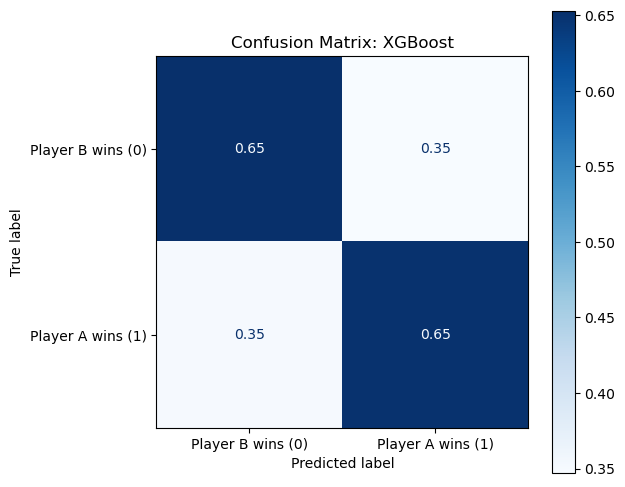

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(best_model_true, best_model_pred, labels=[0, 1], normalize="true")
#cm_normalized = cm / cm.sum()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Player B wins (0)", "Player A wins (1)"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix: XGBoost")
plt.show()

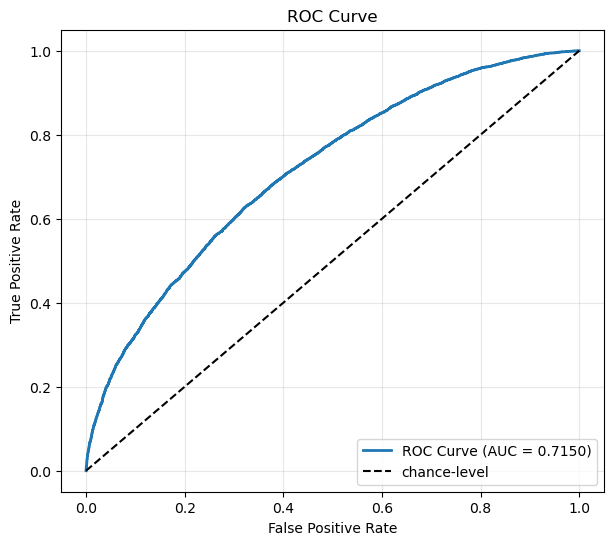

ROC AUC Score: 0.7150


In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

best_model = loaded_data['best_model']
X_test = loaded_data['best_model_X']
best_model_true = loaded_data['best_model_y_true'].to_numpy()

# Get prediction probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(best_model_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="chance-level")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


In [8]:
print(X_test.shape)

(17958, 989)


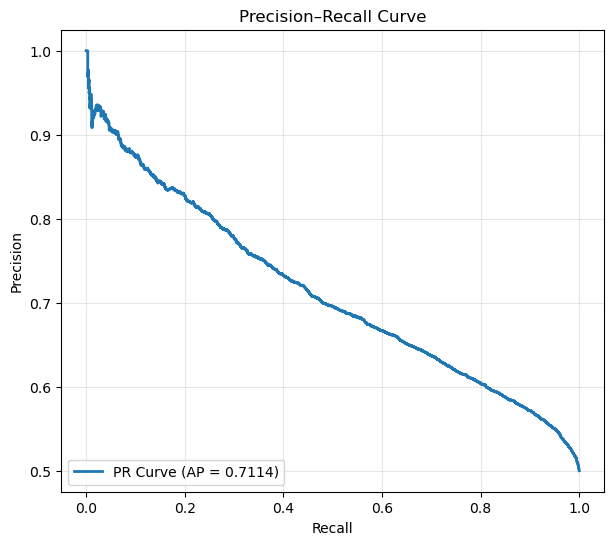

Average Precision (AP): 0.7114


In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision–recall curve
precision, recall, thresholds = precision_recall_curve(best_model_true, y_proba)

# Average precision score (area under PR curve)
ap = average_precision_score(best_model_true, y_proba)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, linewidth=2, label=f"PR Curve (AP = {ap:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(alpha=0.3)
plt.legend(loc="lower left")
plt.show()

print(f"Average Precision (AP): {ap:.4f}")


<Figure size 600x500 with 0 Axes>

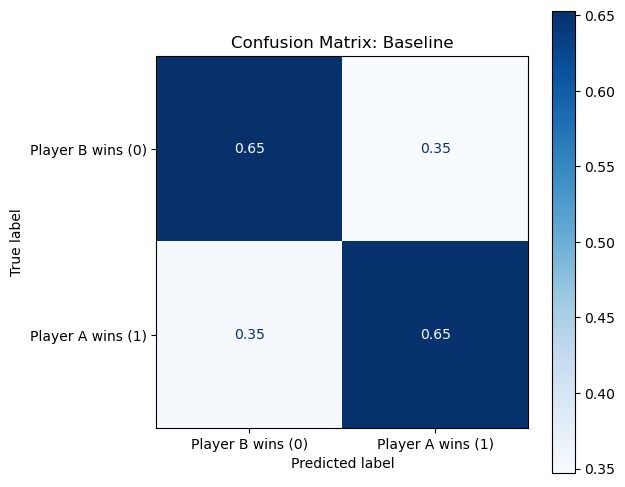

In [37]:
cm_base = confusion_matrix(best_model_true, baseline_preds, normalize="true")

plt.figure(figsize=(6,5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Player B wins (0)", "Player A wins (1)"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format=".2")
plt.title("Confusion Matrix: Baseline")
plt.show()

In [60]:
import pandas as pd

xgb_model = loaded_data['best_model'].named_steps["model"]
feature_names = loaded_data["feature_names"]      # This is a numpy array

booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type="gain")

rows = []
for i, fname in enumerate(feature_names):
    fkey = f"f{i}"                     # XGBoost feature naming convention
    score = importance_dict.get(fkey, 0)
    rows.append((fname, score))

imp_df = pd.DataFrame(rows, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False)

print(imp_df.head(20))


                                  feature  importance
948                    std__Player_seed_B  177.605759
942                    std__Player_seed_A  174.142059
945                    std__Player_rank_A   78.762283
951                    std__Player_rank_B   75.855774
952              std__Player_rankpoints_B   58.660225
946              std__Player_rankpoints_A   57.721703
3                            ord__best_of   21.441036
2                              ord__round   20.427612
987  std__last5_Player_bpFaced_per_SvGm_B   19.553146
970  std__last5_Player_bpFaced_per_SvGm_A   17.709963
966        std__last5_Player_pct_1stWon_A   16.931820
983        std__last5_Player_pct_1stWon_B   16.886578
963           std__last5_Player_bpFaced_A   16.153755
1                      ord__tourney_level   14.725277
949                      std__Player_ht_B   14.528297
980           std__last5_Player_bpFaced_B   14.469759
0                          ord__draw_size   14.434893
943                      std

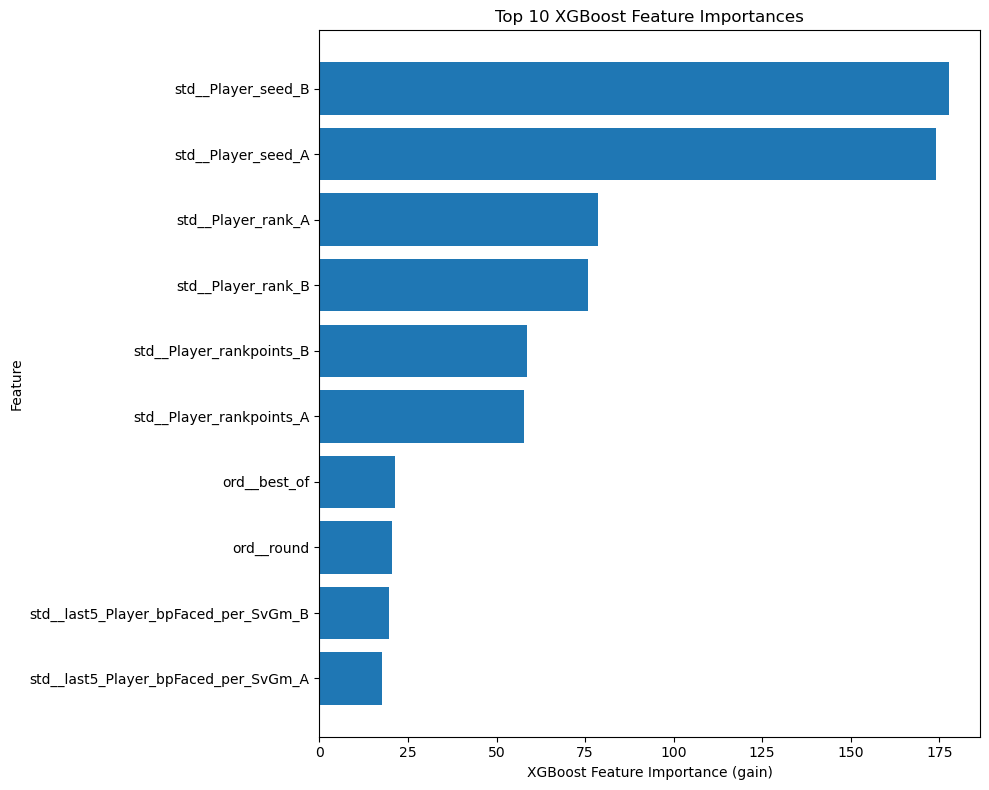

In [62]:
import matplotlib.pyplot as plt

# Sort by importance
imp_sorted = imp_df.sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(10, 8))
plt.barh(imp_sorted["feature"], imp_sorted["importance"])
plt.gca().invert_yaxis()  # Highest importance at the top

plt.xlabel("XGBoost Feature Importance (gain)")
plt.ylabel("Feature")
plt.title("Top 10 XGBoost Feature Importances")
plt.tight_layout()
plt.show()


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

xgb_model = loaded_data['best_model'].named_steps["model"]
feature_names = loaded_data['feature_names']

booster = xgb_model.get_booster()

# Get importance dictionary
importance_dict = booster.get_score(importance_type="gain")

# Correctly align importance by feature index
rows = []
for fname in feature_names:
    # Each XGBoost feature is named f0, f1, f2, ...
    fkey = f"f{feature_names.index(fname)}"
    importance_value = importance_dict.get(fkey, 0)
    rows.append((fname, importance_value))

imp_df = pd.DataFrame(rows, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False)

print(imp_df.head(20))

AttributeError: 'numpy.ndarray' object has no attribute 'index'